In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import math

In [2]:
G = 10E9

xx, yy = np.meshgrid(np.arange(50), np.arange(50))

carrier_frequency = 2 * G

g1, g2, g3, g4 = 32.4, 14, 15, 0.5 

w = 20

step_size = 0.01

n_users_floor = 20

height_floors = 5

max_iterations = 500

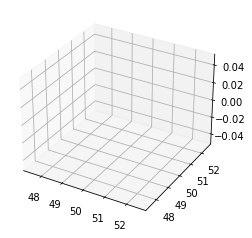

In [19]:
coordinates_uav = [0, 0, 0]

distance_user_building, distance_drone_user, theta = 0, 0, 0  

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot3D(50, 50, 0, color='black', alpha=0.2)
ax.plot3D(50, 50, 200, color='black', alpha=0.2)

plt.show()
